In [1]:
import networkx as nx
import pandas as pd
from tqdm import tqdm
from glob import glob
from collections import Counter

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
fp = fm.FontProperties(fname=font_path)

jsons = glob('tweets/*.json')
for i, f in enumerate(jsons):
    print(i,f)

0 tweets/#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
1 tweets/#ธรรมศาสตร์และการชุมนุม.json
2 tweets/#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
3 tweets/#25พฤศจิกาไปSCB.json
4 tweets/#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
5 tweets/#ม็อบ2ธันวา.json


In [3]:
df = pd.read_json(jsons[3], lines=True)
df = df[df.reply_to.apply(len) > 0]
df[['username','reply_to']]

,username,reply_to
24,sunjoji,"[{'screen_name': 'rudeauron', 'name': 'coco in..."
25,sunjoji,"[{'screen_name': 'rudeauron', 'name': 'coco in..."
41,demidemo5,"[{'screen_name': 'artteen', 'name': 'voravit',..."
47,pedroalvesw,"[{'screen_name': 'idolshelpffxofi', 'name': 'F..."
48,pedroalvesw,"[{'screen_name': 'Anitta', 'name': 'Anitta', '..."
...,...,...
48424,tantanland999,"[{'screen_name': 'FreeYOUTHth', 'name': 'FreeY..."
48438,mr_intouch,"[{'screen_name': 'charoenpura', 'name': 'ITRC ..."
48461,mr_intouch,"[{'screen_name': 'FreeYOUTHth', 'name': 'FreeY..."
48669,oonginlavender,"[{'screen_name': 'AmaratJeab', 'name': 'อมรัตน..."


In [4]:
reply = pd.DataFrame(columns=['replier','replyee'])

for i, row in df.iterrows():
    for dic in row['reply_to']:
            reply.loc[len(reply)] = [row['username'], dic['screen_name']]

In [5]:
reply

,replier,replyee
0,sunjoji,rudeauron
1,sunjoji,rudeauron
2,demidemo5,artteen
3,pedroalvesw,idolshelpffxofi
4,pedroalvesw,Anitta
...,...,...
517,tantanland999,FreeYOUTHth
518,mr_intouch,charoenpura
519,mr_intouch,FreeYOUTHth
520,oonginlavender,AmaratJeab


# network

In [15]:
G = nx.DiGraph()  # Directed Graph

G.add_edges_from(list(zip(reply.replier, reply.replyee)))

# ネットワーク全体の次数の平均値を計算
average_deg = sum(d for n, d in G.degree()) / G.number_of_nodes()

# ノードの次数に比例するようにサイズを設定
sizes = [300*deg/average_deg for node, deg in G.degree()]

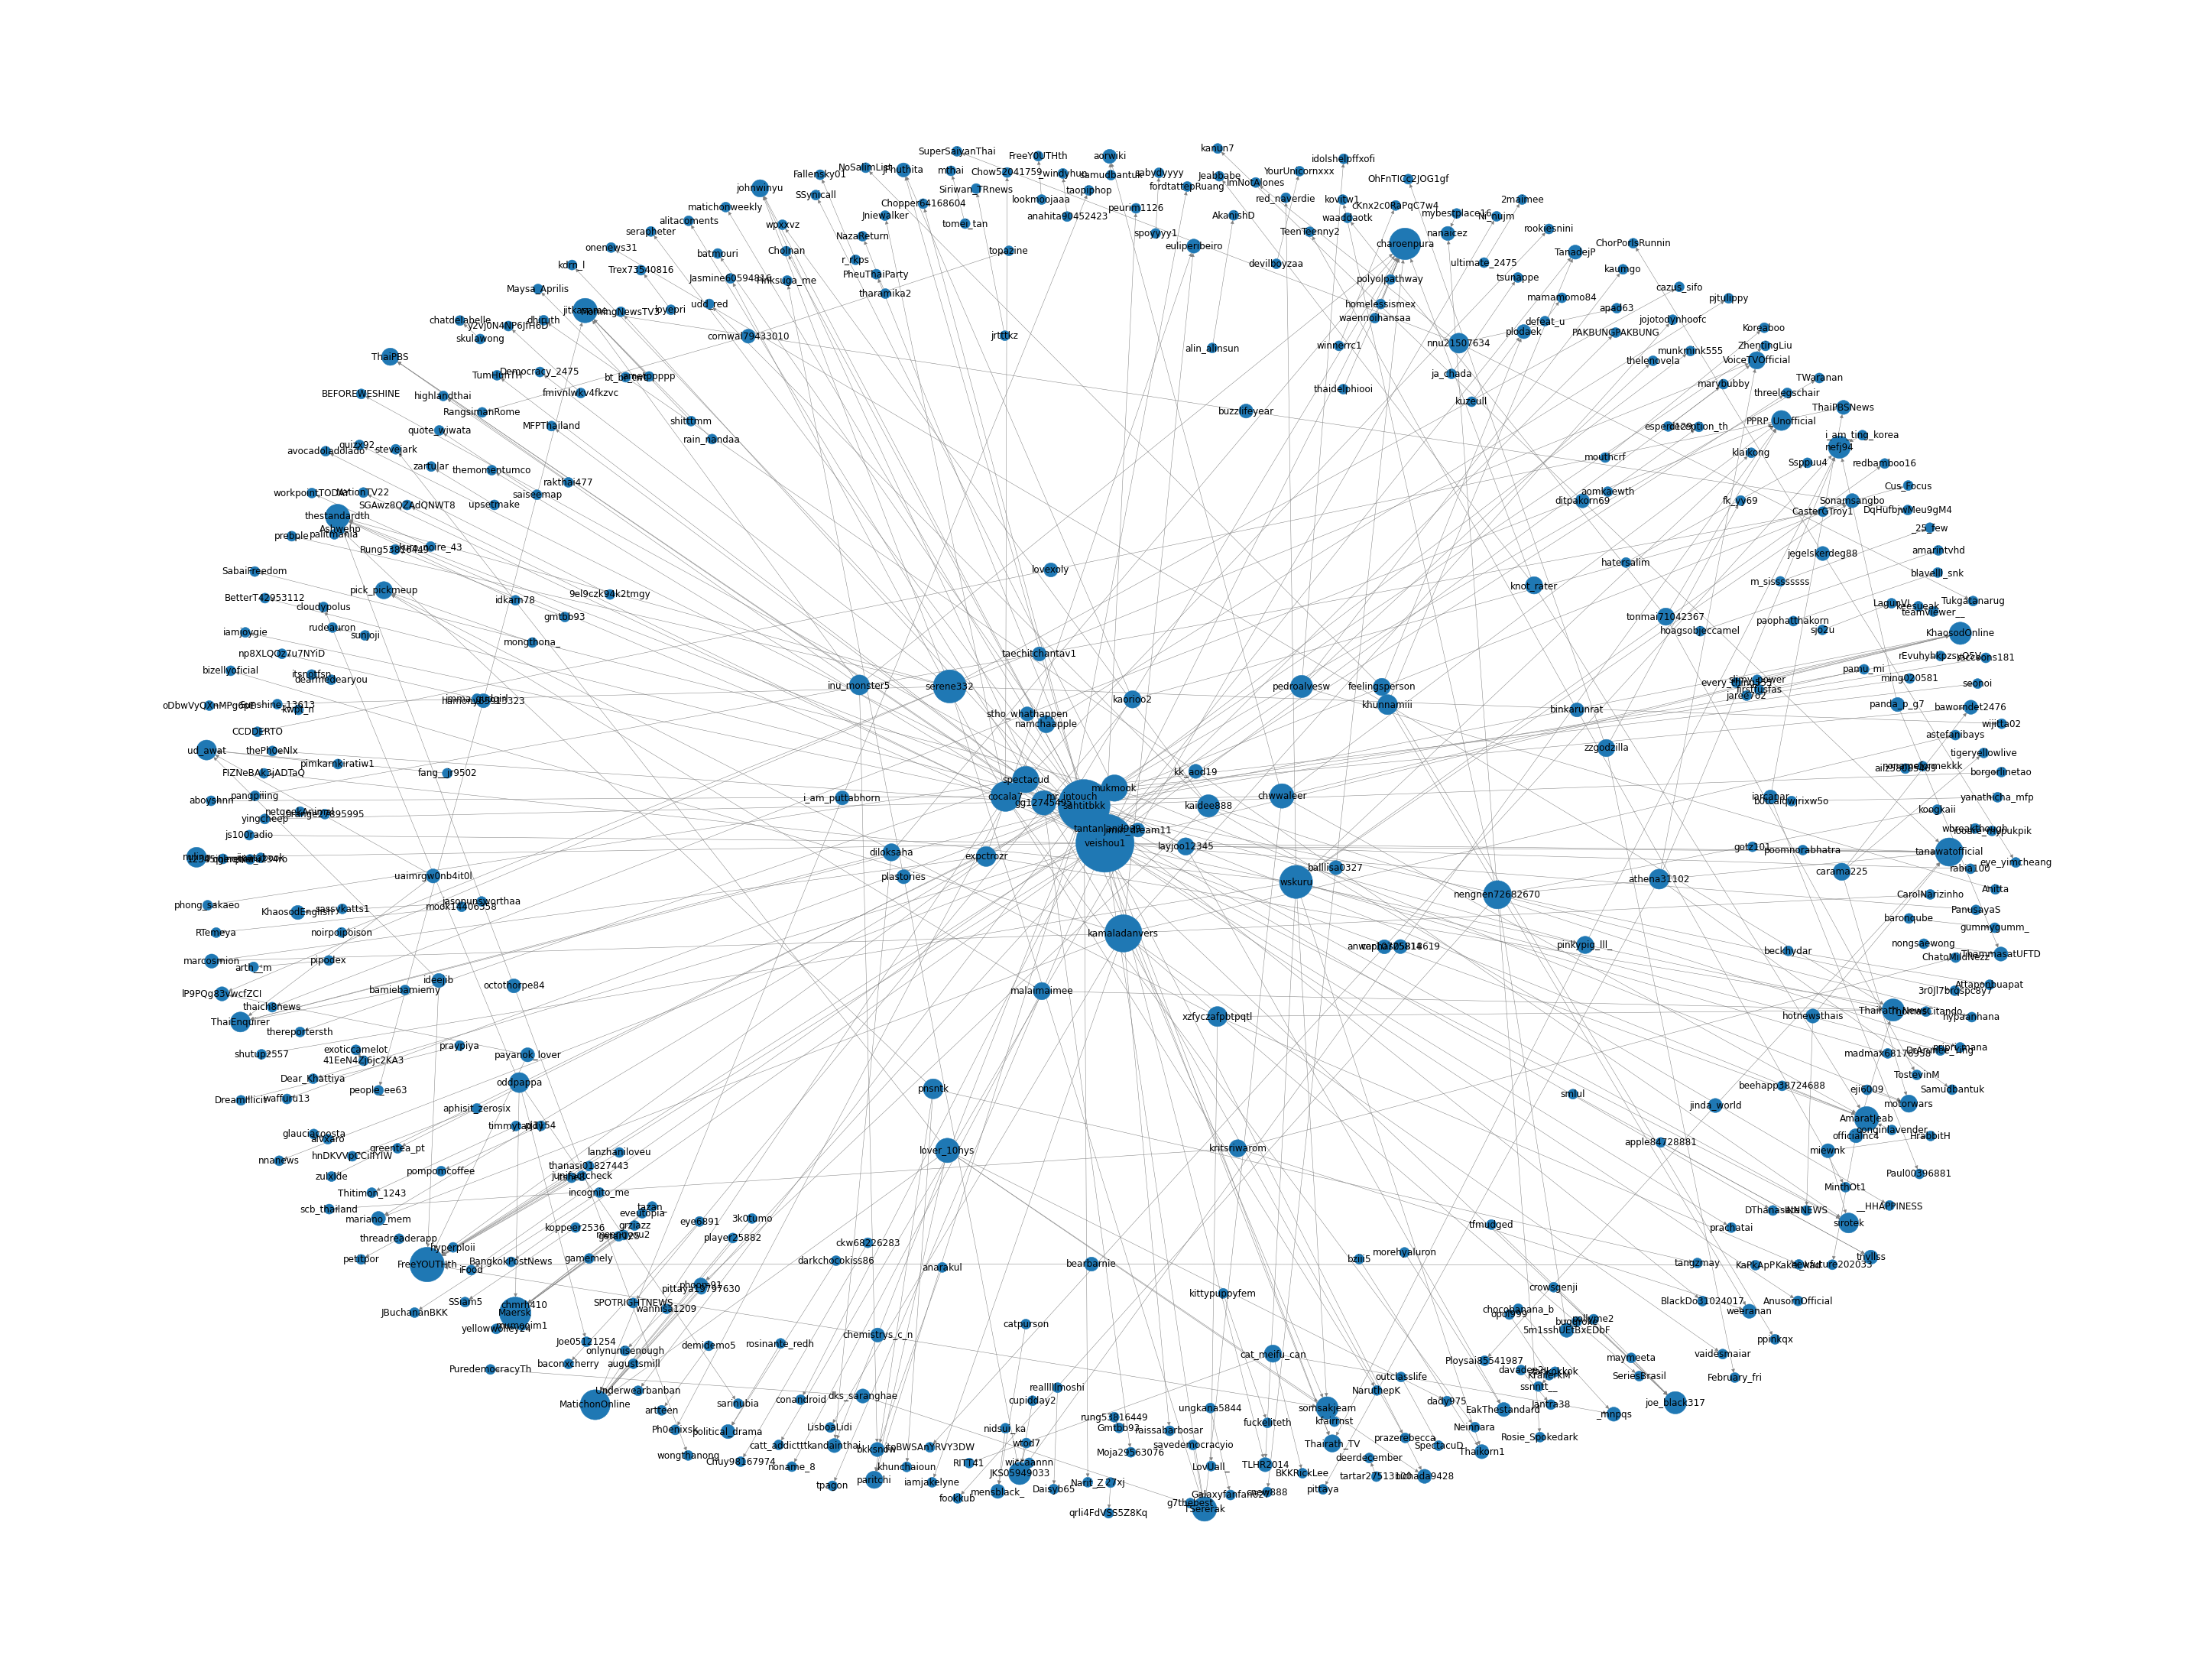

In [16]:
plt.figure(figsize=(40,30))
nx.draw(G, with_labels = True, edge_color="gray", node_size=sizes, width=0.5)
plt.show()

In [17]:
nx.nx_agraph.view_pygraphviz(G, prog='fdp') 

('/var/folders/4s/mvdry9457txcvbj4wf_f36br0000gn/T/tmpcz47w37c.png',
 <AGraph <Swig Object of type 'Agraph_t *' at 0x7fc8143be5a0>>)

In [22]:
# repliers

print("|replier|count|\n|:-:|:-:|")
i = 0
for name, count in reply.replier.value_counts().iteritems():
    print(f"|[@{name}](https://twitter.com/{name})|{count}|")
    i += 1
    if i 

|replyee|count|
|:-:|:-:|
|[@veishou1](https://twitter.com/veishou1)|34|
|[@sahtitbkk](https://twitter.com/sahtitbkk)|27|
|[@kamaladanvers](https://twitter.com/kamaladanvers)|14|
|[@FreeYOUTHth](https://twitter.com/FreeYOUTHth)|12|
|[@wskuru](https://twitter.com/wskuru)|11|
|[@serene332](https://twitter.com/serene332)|11|
|[@charoenpura](https://twitter.com/charoenpura)|10|
|[@Maersk](https://twitter.com/Maersk)|10|
|[@MatichonOnline](https://twitter.com/MatichonOnline)|9|
|[@cocala7](https://twitter.com/cocala7)|9|
